In [2]:
%config InlineBackend.figure_format = 'svg' 
# 如果要保存svg格式图片，可以用上面的命令

import os
import numpy as np

import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# %matplotlib inline

# plt.style.use("ggplot")

读取临床病理信息

In [3]:
clinical_info = pd.read_csv("/mnt/DATA/TJMUCH_data_total/70genes_clinicalinfo_full_1202_OK.csv")
print(clinical_info.columns)
use_info = clinical_info.loc[:, ["slide_id", "初诊年龄", "ER数值\t", "PR数值\t", "Ki67\t", "P53数值\t",
                                 "HER2\t", "HER2status", "MMPrisk", "MMP_index"]]
use_info.rename(columns={'初诊年龄':'age', 'ER数值\t':'ER', 'PR数值\t':'PR', 'Ki67\t': 'Ki67',
                         'P53数值\t': 'P53', 'HER2\t': 'HER2score'}, inplace = True)

use_info = use_info.replace("Unknown", np.nan)
use_info = use_info[pd.notna(use_info["MMPrisk"])]
# use_info = use_info.dropna(inplace=False)

use_info["MMP_index"] = use_info["MMP_index"].astype(float)

use_info["age"] = use_info["age"].astype(int)


use_info

Index(['case_id', 'slide_id', '性别', '初诊年龄', '婚姻状况', '民族', '入院日期', '入院前发现时长',
       '是否生育', '初产年龄', '末胎年龄', '怀孕次数', '足月产次数', '流产和或早产次数', '是否母乳喂养', '哺乳侧别',
       '哺乳时长', '是否有系统疾病（高血压，心脏病，糖尿病，等……）', '具体系统疾病', '是否有乳腺良性手术史', '具体乳腺病史',
       '是否有恶性肿瘤既往史', '具体恶性肿瘤既往史', '是否有恶性肿瘤家族史', '具体恶性肿瘤家族史', '乳腺癌家族史',
       '具体乳腺癌家族史情况', '卵巢癌家族史', '具体卵巢癌家族史情况', '其他恶性肿瘤家族史', '手术日期\t', '手术方式\t',
       '是否全切', '是否保乳\t', '是否再造\t', '肿瘤位置（左、右、双）', '临床TNM分期\t', '病理学分期\t',
       'T分期', 'N分期', 'M分期', '病理类型\t', '病理具体描述', '组织学分级\t', '淋巴管癌栓',
       '间质内浸润淋巴细胞', '腋窝淋巴结总数\t', '阳性腋窝淋巴结数\t', 'ER数值\t', 'ER强度', 'PR数值\t',
       'PR强度', 'HER2\t', 'Ki67\t', 'P53数值\t', 'P53强度', 'FISH',
       'HER2-FISH COPY数', 'HER2-FISH RATIO', 'HER2status', 'MMPrisk',
       'MMP_index', '对应治疗', 'Unnamed: 63'],
      dtype='object')


,slide_id,age,ER,PR,Ki67,P53,HER2score,HER2status,MMPrisk,MMP_index
0,1001,28,90%,40%,15%,不详,0,Negative,High,-0.184
1,1002,46,95%,95%,20-25%,< 5%,1+,Negative,Low,0.223
2,1003,32,90%,90%,30%,不详,1+,Negative,Low,0.145
3,1004,44,90%,90%,15%～20%,1%,2+,Negative,Low,0.395
4,1006,48,90%,90%,10%,< 1%,1+,Negative,High,-0.240
...,...,...,...,...,...,...,...,...,...,...
483,6046,48,80%,70%,10%,1%,-,NaN,Low,0.343
484,6047,48,80%,70%,15%～20%,1%,-,NaN,Low,0.232
485,6048,73,90%,90%,20%,< 1%,-,NaN,Low,0.549
486,6049,61,60%,5%,30%,60%,-,NaN,High,-0.420


下面代码是直接读取五次csv文件，在dataframe中mean prob值，然后只做一次临床数据评估，结果 87/161

In [4]:
exp_name = "new_PhiTrans_align_sim_tile5ktwice500"
root_path = "/home/cyyan/Projects/HER2proj/models/HEROHE/HER2status"

filename = "eval_TJMUCH70genes_res.csv"


pred_info = pd.DataFrame()
# for idx in range(5):
#     indep_val_res = pd.read_csv(os.path.join(root_path, exp_name, f"time{idx}", filename))
#     pred_info = pd.concat([pred_info, indep_val_res.pred], axis=1)
# indep_val_res.pred = pred_info.mode(1) # majority mode

neg_info = pd.DataFrame()
pos_info = pd.DataFrame()
for idx in range(5):
    indep_val_res = pd.read_csv(os.path.join(root_path, exp_name, f"time{idx}", filename))
    neg_info = pd.concat([neg_info, indep_val_res.prob_neg], axis=1)
    pos_info = pd.concat([pos_info, indep_val_res.prob_pos], axis=1)

indep_val_res.prob_neg = neg_info.mean(1) # majority mode
indep_val_res.prob_pos = pos_info.mean(1) # majority mode

indep_val_res.pred = np.argmax(np.array([neg_info.mean(1), pos_info.mean(1)]), axis=0)


交集融合预测到的样本和临床信息数据

In [5]:
# 显示所有列
pd.set_option('display.max_columns', 20)
# 显示所有行
pd.set_option('display.max_rows', 10)

common_data = pd.merge(indep_val_res, use_info,how='inner',on='slide_id').iloc[:, 1:]
common_data

,slide_id,prob_neg,prob_pos,pred,label,sim0,sim1,sim2,sim3,sim4,...,sim24,age,ER,PR,Ki67,P53,HER2score,HER2status,MMPrisk,MMP_index
0,1001,0.442506,0.557494,1,0,-0.006811,-0.003511,-0.009856,-0.005943,-0.004318,...,-0.009179,28,90%,40%,15%,不详,0,Negative,High,-0.184
1,1002,0.467705,0.532295,1,0,-0.107929,-0.053603,-0.161138,-0.095854,-0.069727,...,-0.145314,46,95%,95%,20-25%,< 5%,1+,Negative,Low,0.223
2,1003,0.347717,0.652283,1,0,0.115738,0.057610,0.173187,0.102725,0.074745,...,0.156914,32,90%,90%,30%,不详,1+,Negative,Low,0.145
3,1004,0.714305,0.285695,0,0,-0.141915,-0.070418,-0.211943,-0.126106,-0.091743,...,-0.190882,44,90%,90%,15%～20%,1%,2+,Negative,Low,0.395
4,1006,0.382205,0.617795,1,0,-0.114479,-0.056731,-0.170827,-0.101781,-0.074045,...,-0.153469,48,90%,90%,10%,< 1%,1+,Negative,High,-0.240
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
156,2094,0.413238,0.586762,1,0,-0.069435,-0.034333,-0.103443,-0.061781,-0.044938,...,-0.092502,39,65%,90%,20%,15%,0,Negative,Low,0.150
157,2095,0.377286,0.622714,1,0,-0.106022,-0.052563,-0.158218,-0.094247,-0.068565,...,-0.142223,53,90%,80%,5%～10%,不详,0,Negative,Low,0.338
158,2096,0.587944,0.412056,0,0,-0.127638,-0.063321,-0.190536,-0.113432,-0.082524,...,-0.171481,48,90%,90%,15%～20%,10%,0,Negative,Low,0.227
159,2098,0.549270,0.450730,0,0,-0.116877,-0.057900,-0.174423,-0.103937,-0.075618,...,-0.156606,66,90%,1%,20%,< 1%,1+,Negative,Low,0.295


根据 her2 status 的预测prob和MMP的index进行关联

In [6]:
from sklearn.metrics import roc_auc_score, roc_curve
from sklearn.metrics import auc as calc_auc
from sklearn.metrics import classification_report, balanced_accuracy_score, roc_auc_score, roc_curve, precision_recall_curve


neg_data = common_data[common_data['label'] == 0]

print(sum(neg_data.label == neg_data.pred))


auc = roc_auc_score(common_data['label'], common_data['prob_pos'])
# print(auc)
res_dict = classification_report(neg_data['label'], neg_data['pred'], 
                                    target_names=['neg', 'pos'], output_dict=True)
# print(auc)
print(res_dict['neg'])
# res_dict

82
{'precision': 1.0, 'recall': 0.5189873417721519, 'f1-score': 0.6833333333333332, 'support': 158.0}


/home/cyyan/anaconda3/envs/torch20/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/cyyan/anaconda3/envs/torch20/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/cyyan/anaconda3/envs/torch20/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [7]:
exp_name = "new_PhiTrans_align_sim_tile5ktwice500"

filename = "eval_TJMUCH70genes_res.csv"


for idx in range(5):
    indep_val_res = pd.read_csv(os.path.join(root_path, exp_name, f"time{idx}", filename))
    
    common_data = pd.merge(indep_val_res, use_info, how='inner',on='slide_id').iloc[:, 1:]

    neg_data = common_data[common_data['label'] == 0]

    print(sum(neg_data.label == neg_data.pred))

    auc = roc_auc_score(common_data['label'], common_data['prob_pos'])
    # print(auc)
    res_dict = classification_report(neg_data['label'], neg_data['pred'], 
                                        target_names=['neg', 'pos'], output_dict=True)
    # print(auc)
    print(res_dict['neg'])
    # res_dict

(115+61+65+47+140)/(161*5)

115
{'precision': 1.0, 'recall': 0.7278481012658228, 'f1-score': 0.8424908424908425, 'support': 158.0}
61
{'precision': 1.0, 'recall': 0.3860759493670886, 'f1-score': 0.5570776255707762, 'support': 158.0}
65
{'precision': 1.0, 'recall': 0.41139240506329117, 'f1-score': 0.5829596412556054, 'support': 158.0}
47
{'precision': 1.0, 'recall': 0.2974683544303797, 'f1-score': 0.4585365853658536, 'support': 158.0}
140
{'precision': 1.0, 'recall': 0.8860759493670886, 'f1-score': 0.9395973154362416, 'support': 158.0}


/home/cyyan/anaconda3/envs/torch20/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/cyyan/anaconda3/envs/torch20/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/cyyan/anaconda3/envs/torch20/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/cyyan/anacond

0.5316770186335403

/home/cyyan/anaconda3/envs/torch20/lib/python3.8/site-packages/seaborn/axisgrid.py:118: UserWarning: Glyph 65374 (\N{FULLWIDTH TILDE}) missing from current font.
  self._figure.tight_layout(*args, **kwargs)


/home/cyyan/anaconda3/envs/torch20/lib/python3.8/site-packages/IPython/core/events.py:89: UserWarning: Glyph 65374 (\N{FULLWIDTH TILDE}) missing from current font.
  func(*args, **kwargs)
/home/cyyan/anaconda3/envs/torch20/lib/python3.8/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 65374 (\N{FULLWIDTH TILDE}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


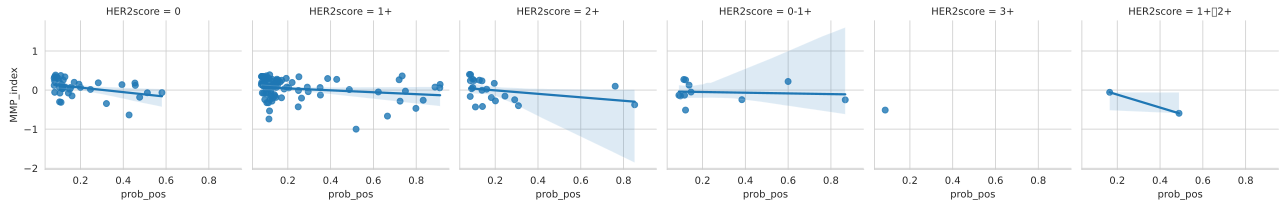

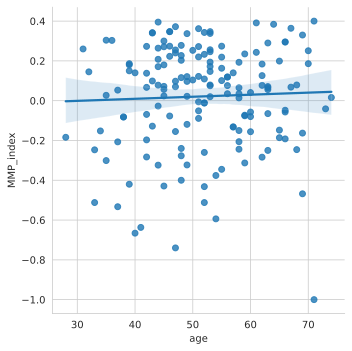

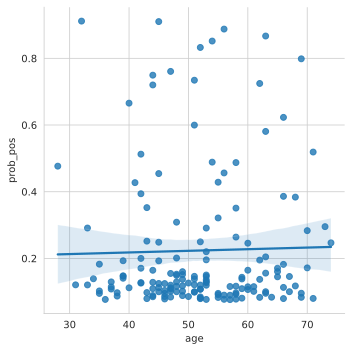

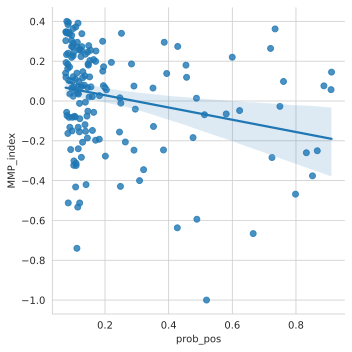

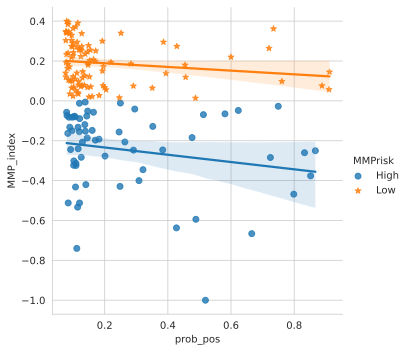

In [10]:
"""
线性回归图  lmplot   或者 regplot
"""

sns.set_style("whitegrid")

sns.lmplot(
    data=common_data, x="prob_pos", y="MMP_index",
    col="HER2score", height=3,
)

# 单一分组参数
sns.lmplot(x="age", y="MMP_index", data=common_data)

# 单一分组参数
sns.lmplot(x="age", y="prob_pos", data=common_data)

sns.lmplot(x="prob_pos", y="MMP_index", data=common_data)

# 分组的线性回归图，hue参数控制分类属性
sns.lmplot(x="prob_pos", y="MMP_index", hue="MMPrisk", markers=["o", "*"],data=common_data)

# col+hue 双分组参数，既分组，又分子图绘制
# 同时控制axes 列数，及 size 尺寸
# sn.lmplot(x="prob_pos", y="MMP_index", col="MMPrisk", hue="MMPrisk",
#                 data=common_data, col_wrap=2)
# plt.savefig("lmplot3.png", dpi=600)

